In [1]:
# Install Dependencies and Datasets
!pip install tokenizers datasets

In [2]:
from datasets import load_dataset

ds = load_dataset("Salesforce/wikitext", "wikitext-2-raw-v1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


# Breaking down Tokenization

In [3]:
from tokenizers import Tokenizer

In [4]:
# We're going to walk this bit of text through tokenization, feel free to change it to something fun
sample_text = "2024 SciFM Summer School! 🤖"

In [5]:
from tokenizers import normalizers
norm = normalizers.Sequence([
    normalizers.Strip(),
    normalizers.Lowercase(),
])
sample_normed = norm.normalize_str(sample_text)
sample_normed

'2024 scifm summer school! 🤖'

In [6]:
from tokenizers import pre_tokenizers
pretok = pre_tokenizers.Sequence([
    pre_tokenizers.Punctuation(),
    pre_tokenizers.Whitespace(),
])
sample_pretok = pretok.pre_tokenize_str(sample_normed)
sample_pretok

[('2024', (0, 4)),
 ('scifm', (5, 10)),
 ('summer', (11, 17)),
 ('school', (18, 24)),
 ('!', (24, 25)),
 ('🤖', (26, 27))]

In [7]:
# Let's start with the basics: Modeling Language as a sequence of Words
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer

tok_wl = Tokenizer(WordLevel(unk_token="[UNK]"))
tok_wl.normalizer = norm
tok_wl.pre_tokenizer = pretok
trainer = WordLevelTrainer(special_tokens=["[UNK]"])  # Don't forget to add the Unknown token!
tok_wl.train_from_iterator(ds["train"]["text"], trainer)

In [8]:
""" Helper function for comparing different tokenizers """
def demo_tokenizer(tok, text=sample_text):
    out = tok.encode(text)
    print(f"Input: `{text}`")
    print(f"Tokens: {out.tokens}")
    print(f"Tokens IDs: {out.ids}")
    print(f"Vocab Size: {tok.get_vocab_size()}")


In [9]:
demo_tokenizer(tok_wl)

Input: `2024 SciFM Summer School! 🤖`
Tokens: ['[UNK]', '[UNK]', 'summer', 'school', '!', '[UNK]']
Tokens IDs: [0, 0, 698, 260, 388, 0]
Vocab Size: 30000


In [10]:
# Some models need extra tokens to deliminate different parts of the input
from tokenizers import processors
from copy import deepcopy

tok_wl_post = deepcopy(tok_wl)
tok_wl_post.add_special_tokens(["[SEP]", "[CLS]"])
tok_wl_post.post_processor = processors.BertProcessing(
    sep=("[SEP]", tok_wl_post.token_to_id("[SEP]")),
    cls=("[CLS]", tok_wl_post.token_to_id("[CLS]")),
)
print(f"Tokenizer a single sentence: {tok_wl_post.encode(sample_text).tokens}")
print(f"A Pair of sentences: {tok_wl_post.encode('Why did the Foundation Model visit the University of Michigan?', sample_text).tokens}")

Tokenizer a single sentence: ['[CLS]', '[UNK]', '[UNK]', 'summer', 'school', '!', '[UNK]', '[SEP]']
A Pair of sentences: ['[CLS]', 'why', 'did', 'the', 'foundation', 'model', 'visit', 'the', 'university', 'of', 'michigan', '?', '[SEP]', '[UNK]', '[UNK]', 'summer', 'school', '!', '[UNK]', '[SEP]']


# Splitting Words into Subwords

## Byte-Pair Encoding

In [11]:
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer

tok_bpe = Tokenizer(BPE(unk_token="[UNK]"))
tok_bpe.normalizer = norm
tok_bpe.pre_tokenizer = pretok
trainer = BpeTrainer(
    vocab_size=tok_wl.get_vocab_size(), # Not a great choice, but helpful for comparison
    special_tokens=["[UNK]"],
    show_progress=True
)
tok_bpe.train_from_iterator(
    ds["train"]["text"],
    trainer,
    length=len(ds["train"])
)

In [12]:
demo_tokenizer(tok_bpe)

Input: `2024 SciFM Summer School! 🤖`
Tokens: ['20', '24', 'sc', 'if', 'm', 'summer', 'school', '!', '[UNK]']
Tokens IDs: [1127, 2045, 1154, 1042, 51, 2917, 1724, 1, 0]
Vocab Size: 30000


## WordPiece

In [13]:
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer

tok_wp = Tokenizer(WordPiece(unk_token="[UNK]"))
tok_wp.normalizer = norm
tok_wp.pre_tokenizer = pretok
trainer = WordPieceTrainer(
    vocab_size=tok_wl.get_vocab_size(), # Not a great choice, but helpful for comparison
    special_tokens=["[UNK]"],
    show_progress=True,
)
tok_wp.train_from_iterator(
    ds["train"]["text"],
    trainer,
    length=len(ds["train"])
)

In [14]:
demo_tokenizer(tok_wp)

Input: `2024 SciFM Summer School! 🤖`
Tokens: ['202', '##4', 'sci', '##f', '##m', 'summer', 'school', '!', '[UNK]']
Tokens IDs: [13237, 966, 26526, 958, 948, 3779, 2443, 1, 0]
Vocab Size: 30000


# Comparing Tokenizers

In [15]:
trained = {
    "WordLevel": tok_wl,
    "BPE": tok_bpe,
    "WordPiece": tok_wp,
}

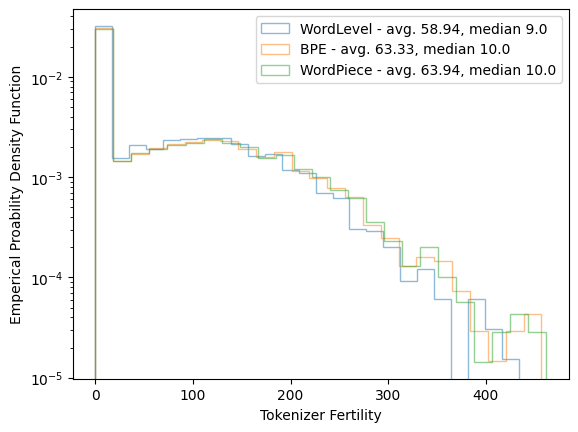

In [16]:
import matplotlib.pyplot as plt
from numpy import mean, median

for name, tok in trained.items():
    fertility = [len(tok.encode(x["text"]).tokens) for x in ds["validation"]]
    label = f"{name} - avg. {mean(fertility):.2f}, median {median(fertility):.1f}"
    plt.hist(fertility, bins="scott", alpha=0.5, label=label, density=True, log=True, histtype='step')

plt.xlabel('Tokenizer Fertility')
plt.ylabel('Emperical Proability Density Function')
plt.legend()
plt.show()

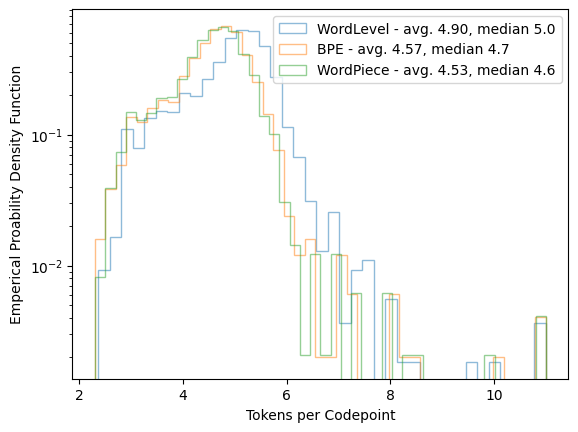

In [17]:
for name, tok in trained.items():
    fertility = [len(x["text"]) / len(tok.encode(x["text"]).tokens) for x in ds["validation"] if len(x["text"]) > 0]
    label = f"{name} - avg. {mean(fertility):.2f}, median {median(fertility):.1f}"
    plt.hist(fertility, bins="scott", alpha=0.5, label=label, density=True, log=True, histtype='step')

plt.xlabel('Tokens per Codepoint')
plt.ylabel('Emperical Proability Density Function')
plt.legend()
plt.show()

In [18]:
num_unknown = dict()
for name, tok in trained.items():
    num_unknown[name] = sum([ tok.model.unk_token in tok.encode(x["text"]).tokens for x in ds["validation"]])

num_unknown

{'WordLevel': 1724, 'BPE': 30, 'WordPiece': 30}